#import and install some dependices

In [ ]:
#scikit learn for  evaluation metrics and for partionning our collected data for training and testing
#mediapipe holistic is used to extract our keypoints, face keypoints ; body hands, saving keypoints as frames 
#tensorflow to train our DL Model (LTSM)  ()
#opencv , cv library acces webpoint for image manipulation
#matplotlib, visualisation


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time #imported to take a sleep  between each frame taken by camera => give us time to take into position 
import mediapipe as mp


#Keypoints using MediaPipe Holistic

a quick sneak peak to the rendering algorithm

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model  : make our detection
mp_drawing = mp.solutions.drawing_utils # Drawing utilities : Drawing detection

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results


In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  #formatting point
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #formatting connection
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    )

In [13]:
# 
cap = cv2.VideoCapture(0) #accessing webcam
# Set mediapipe model     #initial detection value      #preceding tracking confidence
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() 

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully (close while loop)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release() #cam capture no more
    cv2.destroyAllWindows() #close window



<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [14]:
len(results.left_hand_landmarks.landmark) #error will occur until we have a frame

AttributeError: 'NoneType' object has no attribute 'landmark'

In [15]:
results #error will occur until we have a frame



mediapipe.python.solution_base.SolutionOutputs

In [16]:
draw_landmarks(frame, results)

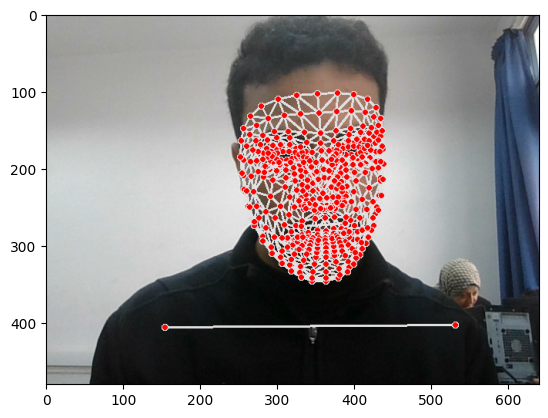

In [17]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#Extract Keypoint Values

**input data**


```
the input data used for this action detection model
is a series of 30 arrays each of which contains 1662 values
(30, 1662)

each of the 30 arrays represents the landmark values (1662 values)
from a single frame.
```



**.flatten()** : Return a copy of the array collapsed into one dimension.

**LTSM** model should work on a **flatten array**



```
gathering needed keypoints for Pose , Face , Left_Hand and Right Hand
for our collection
```



total of pose landmarks = 33*4

total of face landmarks = 468*3

total of left hand landmarks = 21*3

total of right hand landmarks = 21*3


```
33*4 : 33 landmarks with 4 coordinate values each (x,y,z, visibility)
21*3 : 21 landmarks with  3 coordinate values each (x,y,z)
```



In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
result_test = extract_keypoints(results)

NameError: name 'results' is not defined

In [20]:
result_test

array([ 0.56158888,  0.48492759, -1.43036151, ...,  0.        ,
        0.        ,  0.        ])

In [21]:
np.save('0', result_test)


#Setup Folders for Collection

**Action Detection** :
a key difference between action detection and other computer vision tasks
is that **a sequence of data rather than a single frame is used for detection**

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1


we're going to create 1 folder for each action

*Hello*


*   0
*   1
*   ...
*   29

same for *Thanks and Iloveyou*



In [13]:
for action in actions: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))

**Just to recap**


```
We're going to collect 30 videos per action;
then each one of those sequences are going to contain 30 frames of data.
each frame will contain 1662 landmark 
#  conclusion : 3*30 sequences, 30 frames, 1662 landmarks
```



#Collect Keypoint Values for Training and Testing

In [14]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

Remark ▶ 
while collecting sequences , we're going to use **Collection Breaks**


```
having breaks between sequences allows you to reset and reposition yourself
before recording to collect action from start to finish
```


#Preprocess Data and Create Labels and Features

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

train_test_split


```
split our data into a training partition and a testing partition
```

to_catagorical


```
convert your data into one hot encoded data
```




In [16]:
label_map = {label:num for num, label in enumerate(actions)}
# {"hello":0, "thanks": 1, "iloveyou":2}

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [1]:
np.array(sequences).shape

NameError: ignored

In [ ]:
np.array(labels).shape

In [20]:
X = np.array(sequences)

In [21]:
X.shape
#(90, 30, 1662)
## 90 videos, 30 frames, 1662 values 

(90, 30, 1662)

In [18]:
y = to_categorical(labels).astype(int)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) #data partioning : test data are 5% of our total data

#Build and Train LSTM Neural Network

In [23]:
from tensorflow.keras.models import Sequential  #building sequential neural network (API)
from tensorflow.keras.layers import LSTM, Dense #this will allow us to build an LSTM Layer for action detection Neural Network
                                                #dense means fully connected layer
from tensorflow.keras.callbacks import TensorBoard #perform some logging inside of tensorboard if we want to trace or monitor our model as it's training 

In [24]:
log_dir = os.path.join('Logs') #Creating a log directiory
tb_callback = TensorBoard(log_dir=log_dir) #Setup tensorflow callbacks

**TensorBoard**


```
A web app offered as Tensorflow Package that will allow us to monitor our neural network training & accuracy
```



**Tensorflow Callbacks**
```
help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs, create a TensorBoard, etc
```



In [25]:
#Sequential API , makes it easy for you to add extra layers for your model prettystraight forward
model = Sequential()
#adding 3 sets of LSTM layers
               #64 LSTM Units                                #30 frames/prediction * 1662 values
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) # Here "return_sequence=False" because the next layer is a dence layer
                                                               # So we need to not return the sequences to that layer
                                                               # ...Andrew ing's deep learning specialization...

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

**return_sequence = True** 

```
When you are using Tensorflow with an LSTM layer
if you are going to stack them up together, you need to return the sequences because the next layer will need those
```



In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

**loss='categorical_crossentropy'**

```
this is the loss function that you need to use when you have a multi-class classification model
```



```
# if you had a binary classification model : u'd use 'binary_crossentropy'
# if you were performing regression with your neural network you'd probably use MeanSquaredError
```




In [27]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 117ms/step - loss: 1.2042 - categorical_accuracy: 0.3176
Epoch 2/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.2014 - categorical_accuracy: 0.3647
Epoch 3/2000
3/3 [==============================] - 0s 132ms/step - loss: 1.1470 - categorical_accuracy: 0.2824
Epoch 4/2000
3/3 [==============================] - 1s 209ms/step - loss: 1.1493 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 1s 169ms/step - loss: 1.1869 - categorical_accuracy: 0.3294
Epoch 6/2000
3/3 [==============================] - 0s 137ms/step - loss: 1.0966 - categorical_accuracy: 0.4588
Epoch 7/2000
3/3 [==============================] - 0s 116ms/step - loss: 1.0965 - categorical_accuracy: 0.3765
Epoch 8/2000
3/3 [==============================] - 0s 119ms/step - loss: 0.9919 - categorical_accuracy: 0.5882
Epoch 9/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9428 - categorical_accuracy:

KeyboardInterrupt: 

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

#Make Predictions

res is an array which holds ⏭ probabilities ⏮ **(SOFTMAX activation function)**  like this :


```
res == [[0.7, 0.2, 0.1],
        ...,
         [0.2, 0.3, 0.5]]
```




In [29]:
res = model.predict(X_test)

1/1 [==============================] - 0s 371ms/step


using **np.argmax** function 

```
we will retrive the index of maximum probability inside a sub-array of the res array
i.e np.argmax([0.7, 0.2, 0.1]) is 0
```



In [30]:
actions[np.argmax(res[4])]
#'hello'

'thanks'

In [31]:
actions[np.argmax(y_test[4])]
#'hello'

'thanks'

#Save Weights

In [32]:
model.save('action.h5') #saving calculated weights 

**h5 file**

```
An H5 is one of the Hierarchical Data Formats (HDF) used to store large amount of data. 
It is used to store large amount of data in the form of multidimensional arrays. 
The format is primarily used to store scientific data that is well-organized for quick retrieval and analysis.
```


In [ ]:
del model

In [33]:
model.load_weights('action.h5')

#Evaluation using Confusion Matrix and Accuracy

In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

**multilabel_confusion_matrix **

```
return a confusion matrix to each one of our labels
this enables us to evaluate what's being detected as a true positive and a true negative
and what's being detected as a false positive and false negative
```



In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 50ms/step


**Conversion**

```
running these cells converts the prediction from their one-hot encoded representation to a categorical label 
e.g. 0, 1 or 2 as opposed to [1,0,0], [0,1,0] or [0,0,1]
```



In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]]], dtype=int64)

**Confusion Matrix**

```
the mcm function returns a confusion matrix sorted by the label order
in this case, 0,1,2 aka hello, thanks, ily

this matrix is organized as follows:
[ [TRUE N, FALSE P],
  [FALSE N, TRUE P] ]


```


*     the higher the number in these values ,
  the poorer performing model that you've got




In [38]:
#the higher the number that we get here, the better our model is performing
accuracy_score(ytrue, yhat)

1.0

#Test in Real Time

In [39]:
from scipy import stats

In [40]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

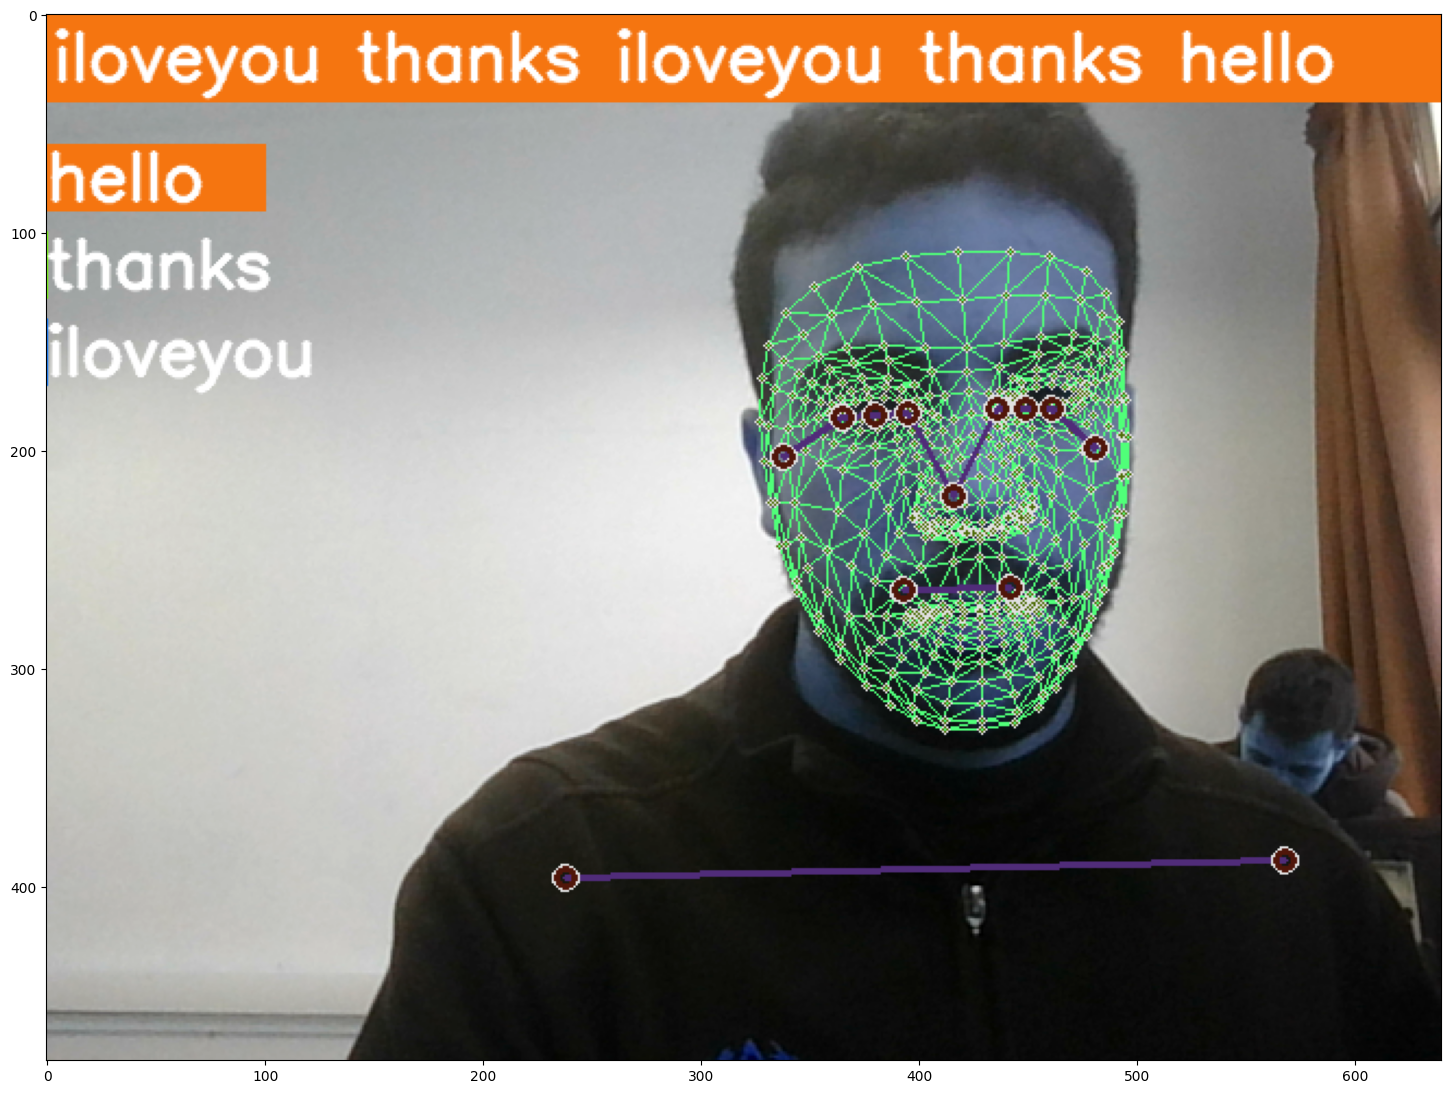

In [44]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

the last cells are helping us render the probabilities visualizations in a modular way using **prob_viz** function and **plotting**

In [43]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5 #Probability thereshold

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

**np.expand_dims(sequence, axis=0)**


```
put the sequence np array in the correct shape ❗ ❗ ❗ as our model is expecting  ❗ ❗ ❗
↪ encapsulate it inside an other array
(30 , 1662) -> (num_sequence, 30, 1662)
```



***in the prediction logic***

1st method:

        sequence.append(keypoints)
        sequence = sequence[-30:]

2nd method:

        sequence.insert(0,keypoints)
        sequence = sequence[0:30]




---



**Append vs Insert**


```
the correct method in this case is append
however we need to grab the last 30 values instead of the first 30,
which is what the next line is currently doing.
```



---

we also added a ***probability threshold*** to make sure that the chosen one is
more likely to be the correct action and not get into confusion between actions
e.g. [0.4, 0.4,0.2] or [0.3, 0.3, 0.4] etc...

---

**Sentence Logic**


```
First, we check if we have words the sentence array. if not, append to it.

if we do, check the current predicted word isn't the same as the previous one.
if it's not,then append. 
if it's the same then skip the append to prevent duplication.
```






---



  

```
if len(sentence) > 5: 
    sentence = sentence[-5:]
```
this code is going to grab only the last values
so that we don't end up with a giant array while rendering






---


```
 np.unique(predictions[-10:])[0]==np.argmax(res)
```

now this code here is
that after appending all our predictions to predictions array it's basically

grabing the last 10 predictions and it's using a **np.unique** function
to make sure the last 10 frames has the last same prediction

▶ this gives us a little more stability when actually predicting our actions

